In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from Vis import ClassificationVis, LabelVis
from Evals import *
from Data_Provider import *
from Util import ClassificationUtils as util
from Util import DataUtils as dutil


import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

/home/emil/miniconda3/envs/emocog/lib/python3.7/site-packages/hypertools/plot/__init__.py:10: UserWarning: Could not switch backend to TkAgg.  This may impact performance of the plotting functions.
  warnings.warn('Could not switch backend to TkAgg.  This may impact performance of the plotting functions.')
/home/emil/miniconda3/envs/emocog/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
#important configs
configs = dutil.load_configs()
print(configs) #is this what we want?

{'sliding': 10, 'wsize': 100, 's_sample': 0, 'e_sample': 30000, 's_sample_ev': 30000, 'e_sample_ev': 35000, 'cutoff': 0.2}


In [4]:
try:
    x,y,x_ev,y_ev = dutil.get_data_from_file(configs)
except:
    raise NameError('File does not exist')


(2839, 89)
(2839,)
(420, 89)
(420,)


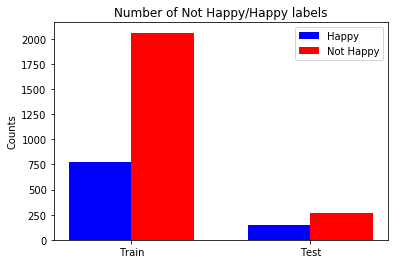

In [5]:
print(x.shape)
print(y.shape)
print(x_ev.shape)
print(y_ev.shape)

LabelVis.plot_happy_bars(y,y_ev)


In [6]:
# Run classifier with cross-validation
cv = StratifiedKFold(n_splits=10,shuffle=False,random_state=1)
results_poly = pd.DataFrame(columns=('C','Gamma','Degree','Avg PR'))#,'AUC ROC'))
degree=np.random.choice(np.arange(10)[1:],50)
cs = np.random.uniform(0,4,50)
gammas = 2**(np.random.choice(18,50)-15.)

for idx,(deg,c,g) in enumerate(zip(degree,cs,gammas)):
    classifier = svm.SVC(C=c,kernel='poly', probability = True,gamma =g,degree=deg,random_state=5)
    auc_pr = util.get_auc_score(classifier, cv, x, y, go_after_pr=True)
    #auc_roc =util.get_auc_score(classifier, cv, x, y, go_after_pr=False)
    results_poly.loc[idx] = [c,g,deg, auc_pr]
    print('Gamma = %.6f, Dim = %d, C= %.2f, Avg PR %.3f' %(g,deg,c,auc_pr))

Gamma = 0.000122, Dim = 2, C= 3.18, Avg PR 0.212
Gamma = 0.062500, Dim = 7, C= 3.31, Avg PR 0.243
Gamma = 0.500000, Dim = 4, C= 1.95, Avg PR 0.210
Gamma = 0.007812, Dim = 4, C= 3.68, Avg PR 0.210
Gamma = 2.000000, Dim = 7, C= 1.16, Avg PR 0.243
Gamma = 0.000061, Dim = 1, C= 3.05, Avg PR 0.201
Gamma = 0.000061, Dim = 3, C= 3.89, Avg PR 0.248
Gamma = 0.000031, Dim = 7, C= 1.81, Avg PR 0.468
Gamma = 0.001953, Dim = 7, C= 1.02, Avg PR 0.233
Gamma = 1.000000, Dim = 7, C= 3.11, Avg PR 0.243
Gamma = 2.000000, Dim = 2, C= 2.02, Avg PR 0.216
Gamma = 0.000488, Dim = 2, C= 2.70, Avg PR 0.205
Gamma = 0.000031, Dim = 4, C= 1.76, Avg PR 0.264
Gamma = 0.007812, Dim = 4, C= 2.01, Avg PR 0.210
Gamma = 0.031250, Dim = 5, C= 0.64, Avg PR 0.216
Gamma = 0.003906, Dim = 6, C= 1.26, Avg PR 0.207
Gamma = 1.000000, Dim = 5, C= 2.98, Avg PR 0.216
Gamma = 0.000061, Dim = 3, C= 0.50, Avg PR 0.262
Gamma = 0.000122, Dim = 2, C= 2.44, Avg PR 0.212
Gamma = 0.031250, Dim = 7, C= 2.34, Avg PR 0.243
Gamma = 1.000000, Di

In [7]:
dutil.save_results(results_poly,configs,'_poly') # save results for later use

In [10]:
best_choice = util.get_best_hyperparas_results(results_poly, col='Avg PR') #what were the best hyperparas?
print(best_choice)
best_c,best_g,best_d =best_choice[:3]


C         1.814574
Gamma     0.000031
Degree    7.000000
Avg PR    0.467586
Name: 7, dtype: float64


0.440466278101582 0.6808236808236808 0.5348837209302326
0.3646112600536193 0.8947368421052632 0.5180952380952382


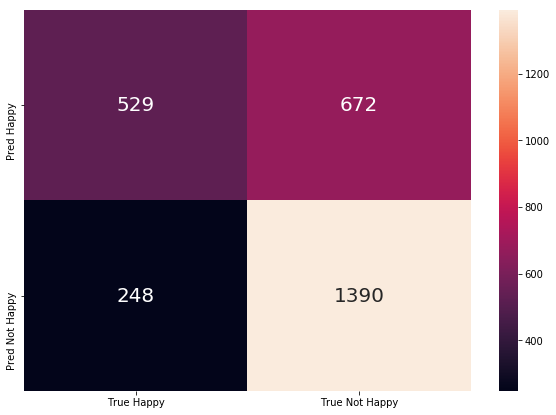

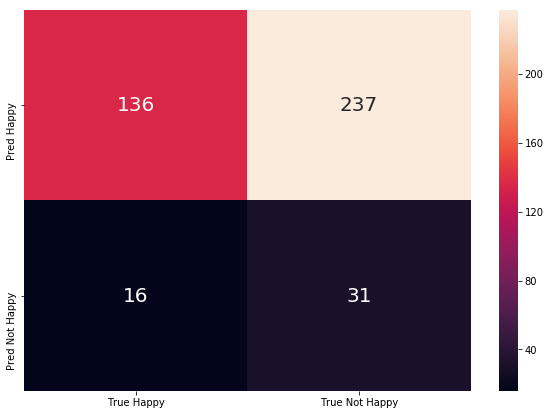

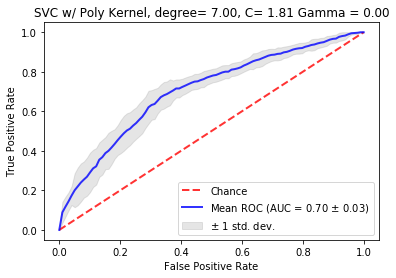

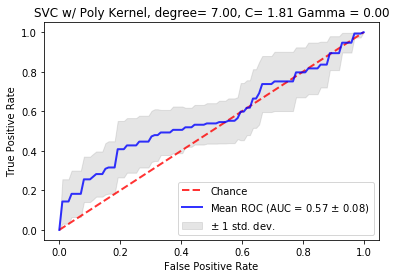

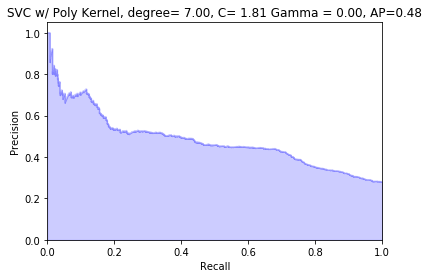

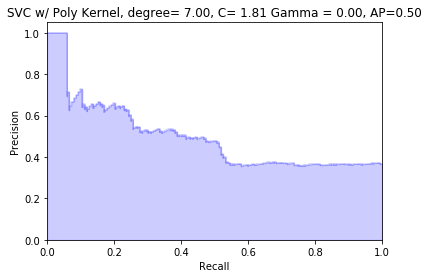

In [11]:
###using hyperpara found, evaluate and get pretty plots

classifier = svm.SVC(C=best_c,kernel='poly', probability = True,gamma =best_g,degree=best_d,random_state=5)
best_thr = util.get_optimal_threshold(classifier, cv, x, y, go_after_pr=True) # get threshold using cv
y_pred,y_pred_ev = util.fit_predict(classifier, best_thr, x, y, x_ev, y_ev) # using that threshold, get predictions and f1 score
f1_tr=get_f1(y_pred,y) # calculate f1 scores for prediction on train set
f1_ev=get_f1(y_pred_ev,y_ev)
prec_tr,recall_tr = get_precision_recall(y_pred,y)
prec_ev,recall_ev = get_precision_recall(y_pred_ev,y_ev)

print(prec_tr, recall_tr,f1_tr)
print(prec_ev, recall_ev,f1_ev)
ClassificationVis.conf_mat(y_pred,y)
ClassificationVis.conf_mat(y_pred_ev,y_ev)
plt.show()

ClassificationVis.plot_roc(x,y,classifier, 'SVC w/ Poly Kernel, degree= {:.2f}, C= {:.2f} Gamma = {:.2f}'.format(best_d,best_c, best_g))
ClassificationVis.plot_roc(x_ev,y_ev,classifier, 'SVC w/ Poly Kernel, degree= {:.2f}, C= {:.2f} Gamma = {:.2f}'.format(best_d,best_c, best_g))
ClassificationVis.plot_pr_curve(x,y,classifier, 'SVC w/ Poly Kernel, degree= {:.2f}, C= {:.2f} Gamma = {:.2f}'.format(best_d,best_c, best_g))
ClassificationVis.plot_pr_curve(x_ev,y_ev,classifier,'SVC w/ Poly Kernel, degree= {:.2f}, C= {:.2f} Gamma = {:.2f}'.format(best_d,best_c, best_g))